In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
np.random.seed(50)

In [3]:
from datetime import date
from matplotlib import pyplot as plt

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, Model
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

In [5]:
import tensorflow as tf
tf.random.set_seed(40)

In [6]:
import matplotlib.pyplot as plt
import datetime as dt 
import urllib.request, json

In [7]:
df = pd.read_csv('https://github.com/cybercat37794/Stock-Price-Prediction/raw/main/Datasets_long/AMZN_long.csv')

In [8]:
print(df)

            Date         Open         High          Low        Close  \
0     1997-05-15     2.437500     2.500000     1.927083     1.958333   
1     1997-05-16     1.968750     1.979167     1.708333     1.729167   
2     1997-05-19     1.760417     1.770833     1.625000     1.708333   
3     1997-05-20     1.729167     1.750000     1.635417     1.635417   
4     1997-05-21     1.635417     1.645833     1.375000     1.427083   
...          ...          ...          ...          ...          ...   
6279  2022-04-27  2803.830078  2838.969971  2715.669922  2763.340088   
6280  2022-04-28  2843.560059  2918.750000  2806.000000  2891.929932   
6281  2022-04-29  2596.979980  2615.219971  2432.500000  2485.629883   
6282  2022-05-02  2448.020020  2493.360107  2367.500000  2490.000000   
6283  2022-05-03  2481.070068  2524.409912  2456.500000  2485.070068   

        Adj Close    Volume  
0        1.958333  72156000  
1        1.729167  14700000  
2        1.708333   6106800  
3        1.6354

In [9]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
stockprices = df.sort_values('Date')

In [11]:
def calculate_rmse(y_actual, y_predict):
    """
    Calculate the Root Mean Squared Error (RMSE)
    """
    rmse = np.sqrt(np.mean((y_actual - y_predict)**2))
    return rmse

In [12]:
def calculate_mape(y_actual, y_predict):
    """
    Calculate the Mean Absolute Percentage Error (MAPE)
    """
    y_predict, y_actual = np.array(y_predict), np.array(y_actual)
    mape = np.mean(np.abs((y_actual - y_predict) / y_actual)) * 100
    return mape

In [13]:
def extract_seqX_outcomeY(data, N, offset_value):
    """
    Split time-series into training sequence X and outcome value Y
    Args:
    data - dataset
    N - window size, e.g., 60 for 60 days
    offset_value - position to start the split
    """
    training_Sequence_X = []
    output_value_y = []

    for i in range(offset_value, len(data)):
        training_Sequence_X.append(data[i-N:i])
        output_value_y.append(data[i])

    return np.array(training_Sequence_X), np.array(output_value_y)

In [15]:
test_ratio = 0.2
training_ratio = 0.8

training_size = int(training_ratio * len(stockprices))
testing_size = int(test_ratio * len(stockprices))

print('training_size: ' + str(training_size))
print('testing_size: ' + str(testing_size))

train = stockprices[:5027][['Date', 'Close']]
test = stockprices[5028:][['Date', 'Close']]

print(train.shape)
print(test.shape)

training_size: 5027
testing_size: 1256
(5027, 2)
(1256, 2)


In [16]:
stockprices = stockprices.set_index('Date')

In [17]:
def plotting_stock_trend(var, current_title, stockprices=stockprices):
    ax = stockprices[['Close', var, '200day']].plot(figsize = (20, 10))
    plt.grid(False)
    plt.title(current_title)
    plt.axis('tight')
    plt.ylabel('Stock Price ($)')

def calculate_perform_metrics(var):
    ### Root mean squared error
    rmse = calculate_rmse(np.array(stockprices[training_size:]['Close']), np.array(stockprices[training_size:][var]))
    ### Mean absolute percentage error
    mape = calculate_mape(np.array(stockprices[training_size:]['Close']), np.array(stockprices[training_size:][var]))

    return rmse, mape
    

In [18]:
window_size = 50

RMSE: 154.8827584443756
MAPE %: 5.316210871036059


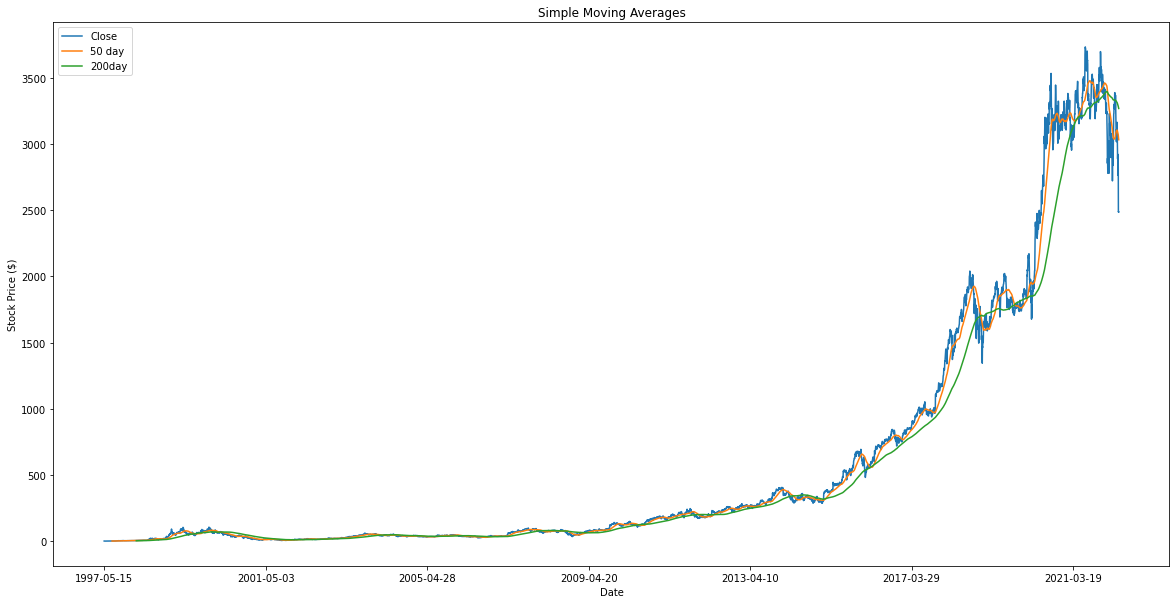

In [19]:
window_variable = str(window_size) + ' day'

stockprices[window_variable] = stockprices['Close'].rolling(window_size).mean()
### for reference, include 200 day simple moving average
stockprices['200day'] = stockprices['Close'].rolling(200).mean()

### plotting and performance metrics for simple moving average model
plotting_stock_trend(var = window_variable, current_title = 'Simple Moving Averages')
rmse_sma, mape_sma = calculate_perform_metrics(var=window_variable)
print('RMSE:', rmse_sma)
print('MAPE %:', mape_sma)

RMSE: 139.41070037360677
MAPE %: 4.729888970254782


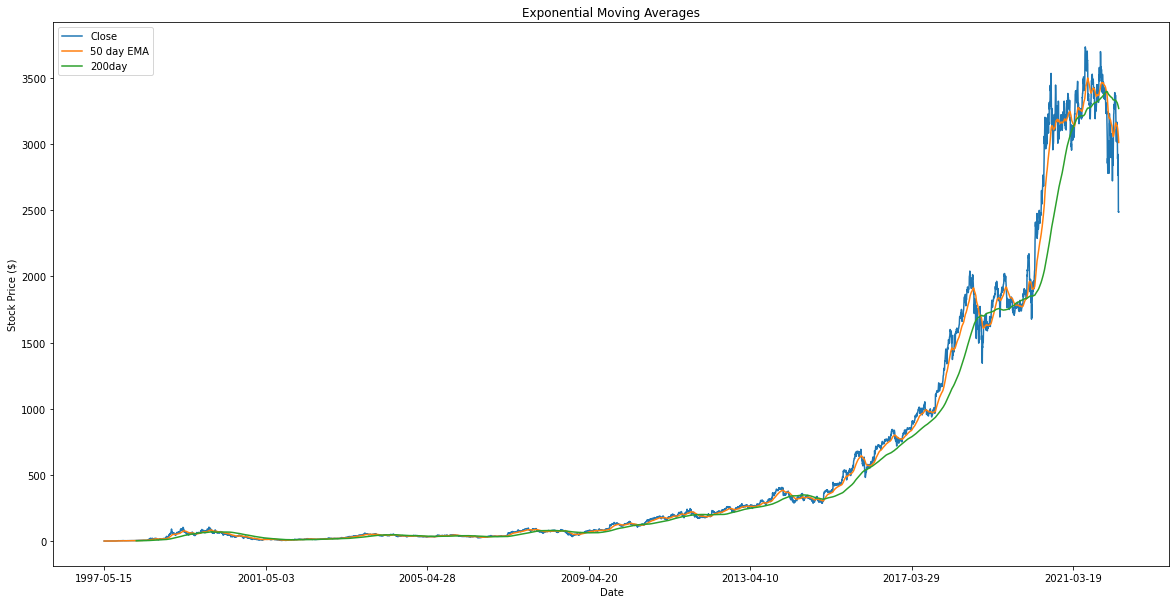

In [20]:
### Exponential MA
window_ema_variable = str(window_size) + ' day' + ' EMA'
# Calculate the exponentially weighted moving average for the Nth day
stockprices[window_ema_variable] = stockprices['Close'].ewm(span = window_size, adjust = False).mean()
stockprices['200day'] = stockprices['Close'].rolling(200).mean()

### plotting and performance metrics for exponential moving average model
plotting_stock_trend(var = window_ema_variable, current_title = 'Exponential Moving Averages')
rmse_ema, mape_ema = calculate_perform_metrics(var = window_ema_variable)
print('RMSE:', rmse_ema)
print('MAPE %:', mape_ema)

Epoch 1/15
150/150 [==============================] - 19s 105ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 2/15
150/150 [==============================] - 14s 94ms/step - loss: 7.4645e-05 - val_loss: 0.0040
Epoch 3/15
150/150 [==============================] - 9s 60ms/step - loss: 7.0614e-05 - val_loss: 0.0036
Epoch 4/15
150/150 [==============================] - 7s 49ms/step - loss: 7.0930e-05 - val_loss: 0.0036
Epoch 5/15
150/150 [==============================] - 7s 48ms/step - loss: 7.2294e-05 - val_loss: 0.0032
Epoch 6/15
150/150 [==============================] - 7s 48ms/step - loss: 7.1875e-05 - val_loss: 0.0035
Epoch 7/15
150/150 [==============================] - 7s 49ms/step - loss: 6.9188e-05 - val_loss: 0.0029
Epoch 8/15
150/150 [==============================] - 7s 49ms/step - loss: 7.1024e-05 - val_loss: 0.0028
Epoch 9/15
150/150 [==============================] - 8s 55ms/step - loss: 7.0262e-05 - val_loss: 0.0027
Epoch 10/15
150/150 [==============================] - 7

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


RMSE: 931.3724893231819
MAPE %: 28.27682847131684


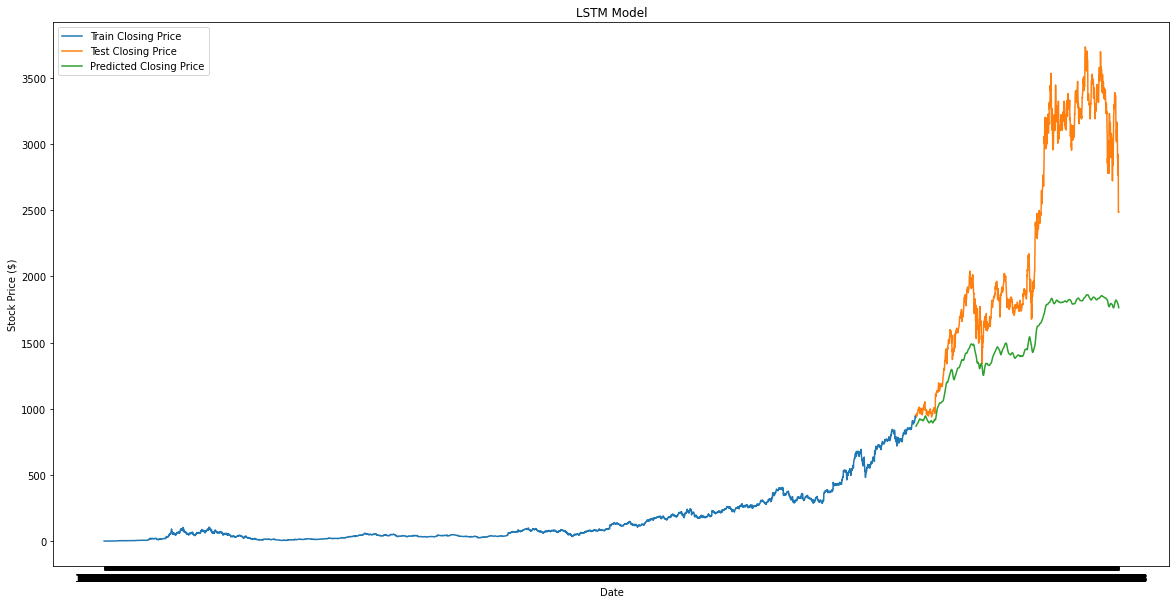

In [22]:
layer_units = 50
optimizer = 'adam'
current_epochs = 15
current_batch_size = 30

current_LSTM_parameters = {'units': layer_units,
                           'optimizer': optimizer,
                           'batch_size': current_batch_size,
                           'epochs': current_epochs
                          }
    
## use the past N stock prices for training to predict the N+1th closing price

# scale 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(stockprices[['Close']])
scaled_data_train = scaled_data[:train.shape[0]]
   
X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)

### build a LSTM model
def Run_LSTM(X_train, layer_units = 50):
    inp = Input(shape=(X_train.shape[1], 1))

    x = LSTM(units=layer_units, return_sequences=True)(inp)
    x = LSTM(units=layer_units)(x)
    out = Dense(1, activation='linear')(x)
    model = Model(inp, out)

    # Compile the LSTM model
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')

    return model
    
model = Run_LSTM(X_train, layer_units = layer_units)

history = model.fit(X_train, y_train, epochs=current_epochs, batch_size=current_batch_size, verbose=1, validation_split=0.1, shuffle=True)

# predicting stock price using past window_size stock prices
def preprocess_test_data(data=stockprices, scaler=scaler, window_size=window_size, test=test): 
    raw = data['Close'][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1,1)
    raw = scaler.transform(raw)

    X_test = []
    for i in range(window_size, raw.shape[0]):
        X_test.append(raw[i-window_size:i, 0])
        
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test
    
X_test = preprocess_test_data()

predicted_price_ = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price_)

# plot predicted price vs actual closing price
test['Predictions_lstm'] = predicted_price

# Evaluate performance
rmse_lstm = calculate_rmse(np.array(test['Close']), np.array(test['Predictions_lstm']))
mape_lstm = calculate_mape(np.array(test['Close']), np.array(test['Predictions_lstm']))


### Plot preidiction and true trends
def plotting_stock_trend_lstm(train, test):        
    fig = plt.figure(figsize = (20,10))
    plt.plot(train['Date'], train['Close'], label = 'Train Closing Price')
    plt.plot(test['Date'], test['Close'], label = 'Test Closing Price')
    plt.plot(test['Date'], test['Predictions_lstm'], label = 'Predicted Closing Price')
    plt.title('LSTM Model')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend(loc="upper left")

plotting_stock_trend_lstm(train, test)

print("RMSE:",rmse_lstm)
print("MAPE %:",mape_lstm)

    